In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import pandas as pd 
import os, json, pickle


In [3]:
import sys 
sys.path.append('../src')

from spaceoracle import SpaceTravLR
from spaceoracle.tools.network import DayThreeRegulatoryNetwork

%config InlineBackend.figure_format = 'retina'

co_grn = DayThreeRegulatoryNetwork()
adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data/day3_lymph_rep_1.h5ad')

2024-11-20 00:09:11.089756: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
from spaceoracle.plotting.layout import *
from spaceoracle.plotting.randomize import *
from spaceoracle.plotting.transitions import * 
from spaceoracle.plotting.niche import *


In [6]:
so = SpaceTravLR(
    adata=adata,
    save_dir='/ix/djishnu/shared/djishnu_kor11/models_v2',
    annot='rctd_cluster', 
    grn=co_grn
)

beta_dict = so._get_spatial_betas_dict()
so.beta_dict = beta_dict

100%|██████████| 2000/2000 [01:05<00:00, 30.38it/s]


In [7]:
goi = 'Il2ra'
betas = beta_dict.data[goi].iloc[:, :-4].values
cell_types = beta_dict.data[goi]['rctd_celltypes']
betas.shape

(11567, 106)

In [8]:
from sklearn.cluster import KMeans

k = 9
kmeans = KMeans(n_clusters=k, random_state=1334).fit(betas)
labels = kmeans.labels_

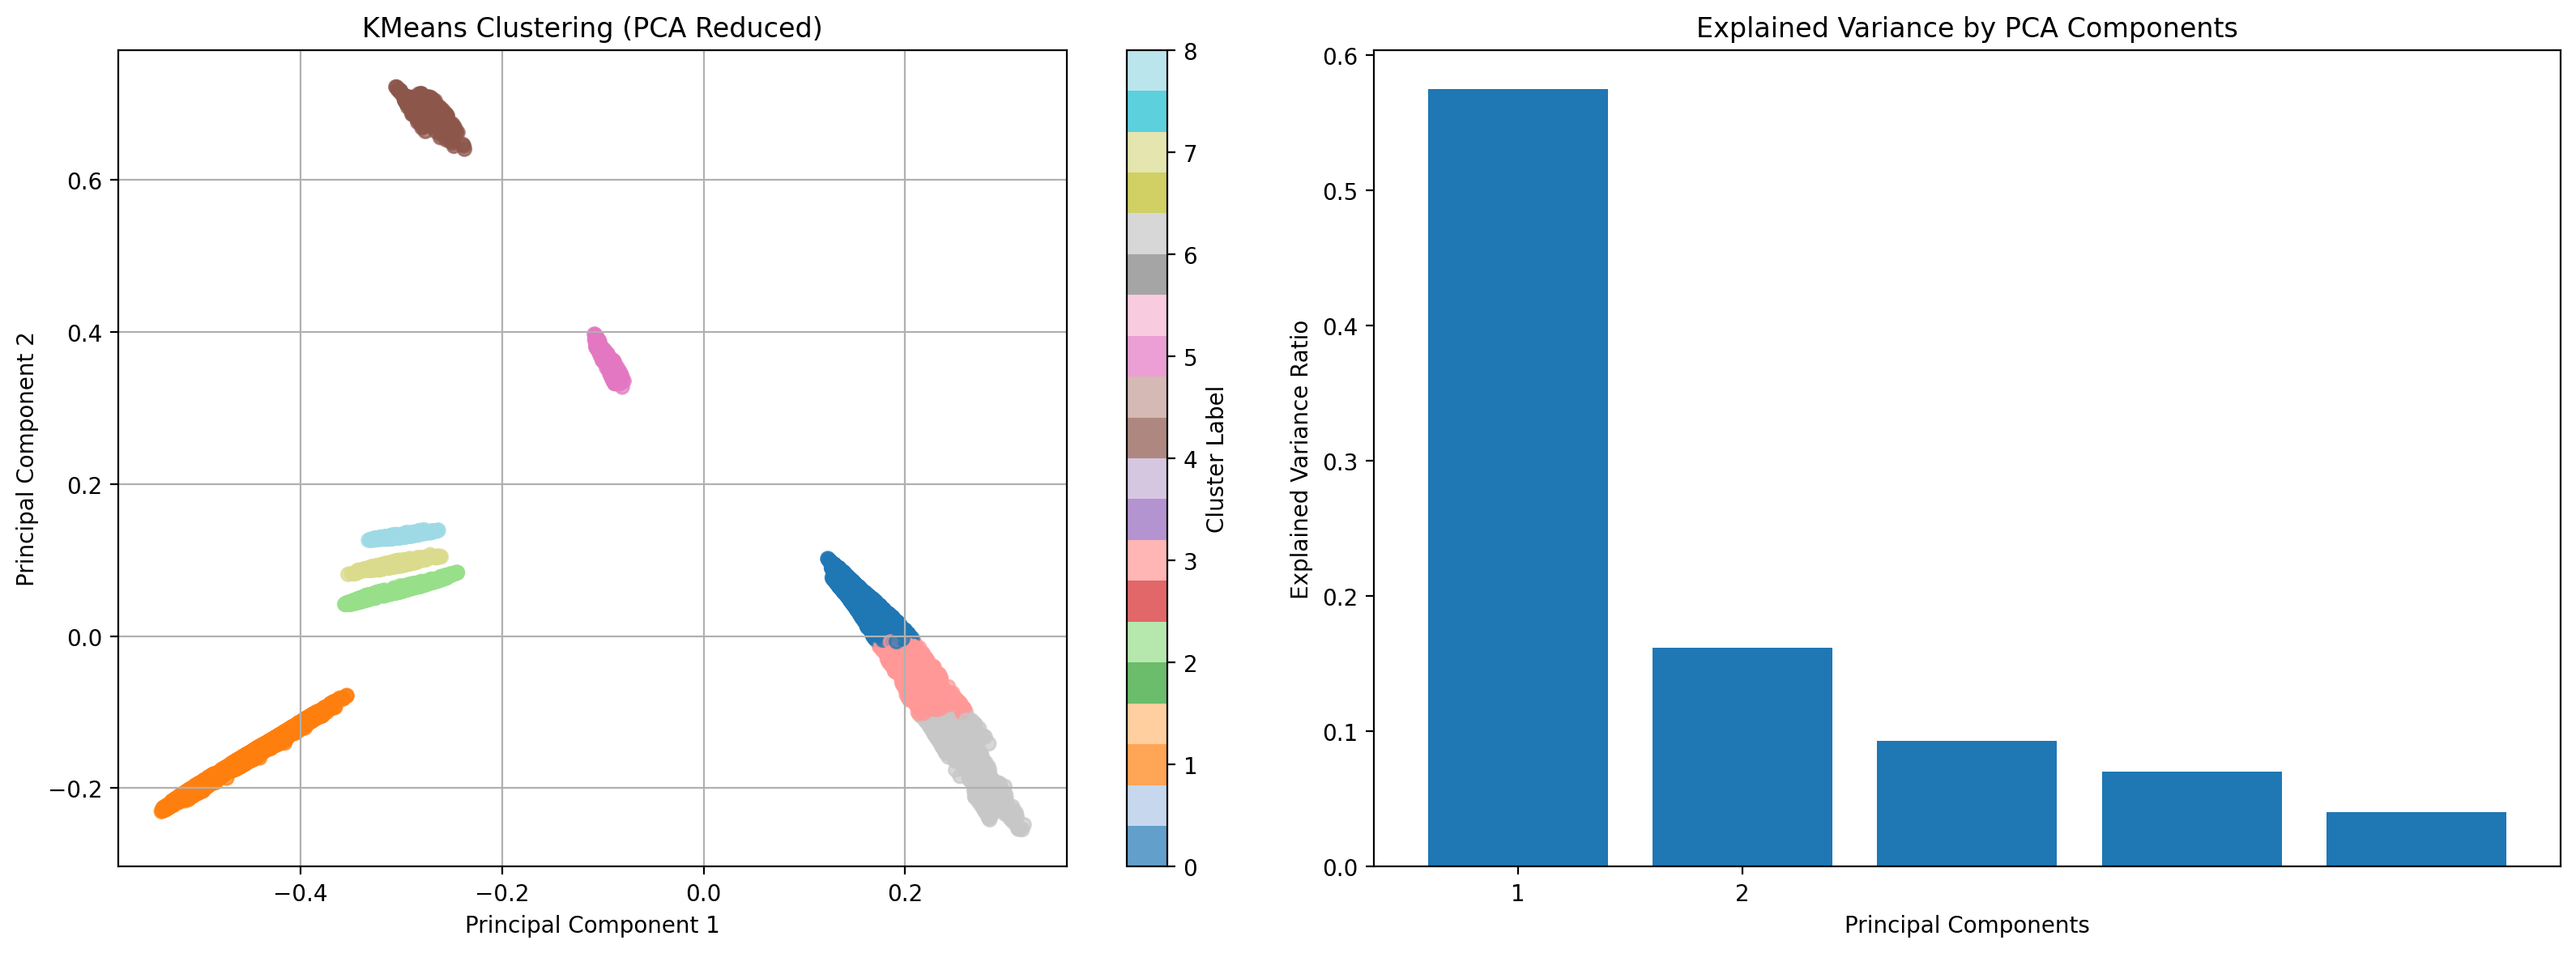

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
betas_pca = pca.fit_transform(betas)

fig, axs = plt.subplots(1, 2, figsize=(16, 6)) 
scatter = axs[0].scatter(betas_pca[:, 0], betas_pca[:, 1], c=labels, cmap='tab20', alpha=0.7)
fig.colorbar(scatter, ax=axs[0], label='Cluster Label')
axs[0].set_title('KMeans Clustering (PCA Reduced)')
axs[0].set_xlabel('Principal Component 1')
axs[0].set_ylabel('Principal Component 2')
axs[0].grid(True)

axs[1].bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
axs[1].set_title('Explained Variance by PCA Components')
axs[1].set_xlabel('Principal Components')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_xticks(range(1, 3))  

plt.tight_layout()
plt.show()

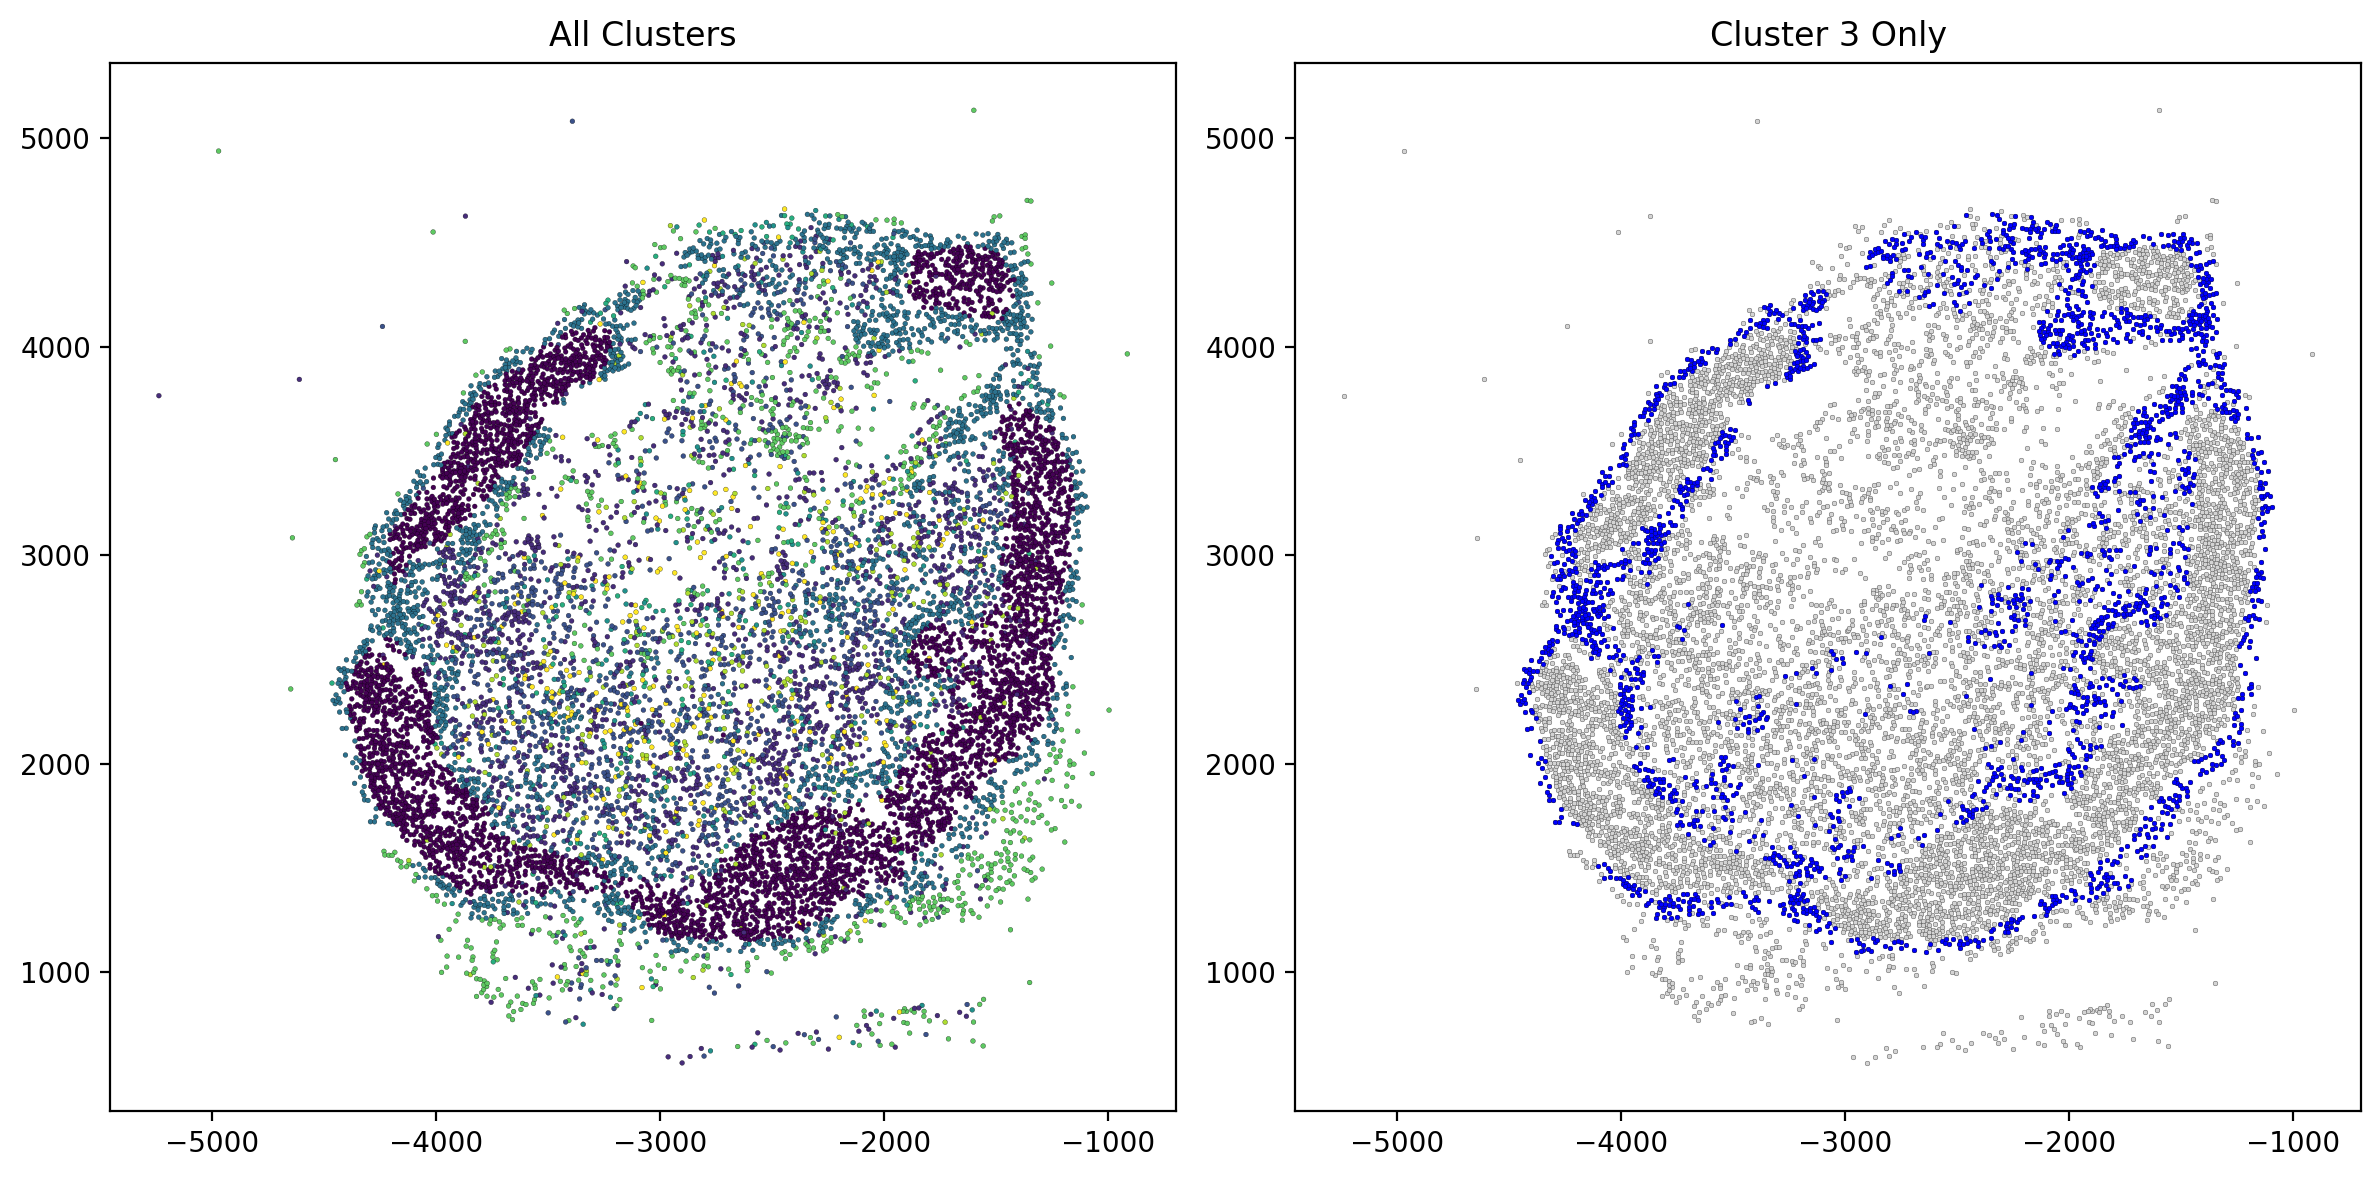

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(
    adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
    c=labels, s=3, edgecolors='black', linewidth=0.1
)
axes[0].set_title('All Clusters')

ko_cluster = 3
highlight = labels == ko_cluster
axes[1].scatter(
    adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
    c='lightgray', s=3, edgecolors='black', linewidth=0.1  
)
axes[1].scatter(
    adata.obsm['spatial'][highlight, 0], adata.obsm['spatial'][highlight, 1],
    c='blue', s=3, edgecolors='black', linewidth=0.1  
)
axes[1].set_title(f'Cluster {ko_cluster} Only')
plt.tight_layout()


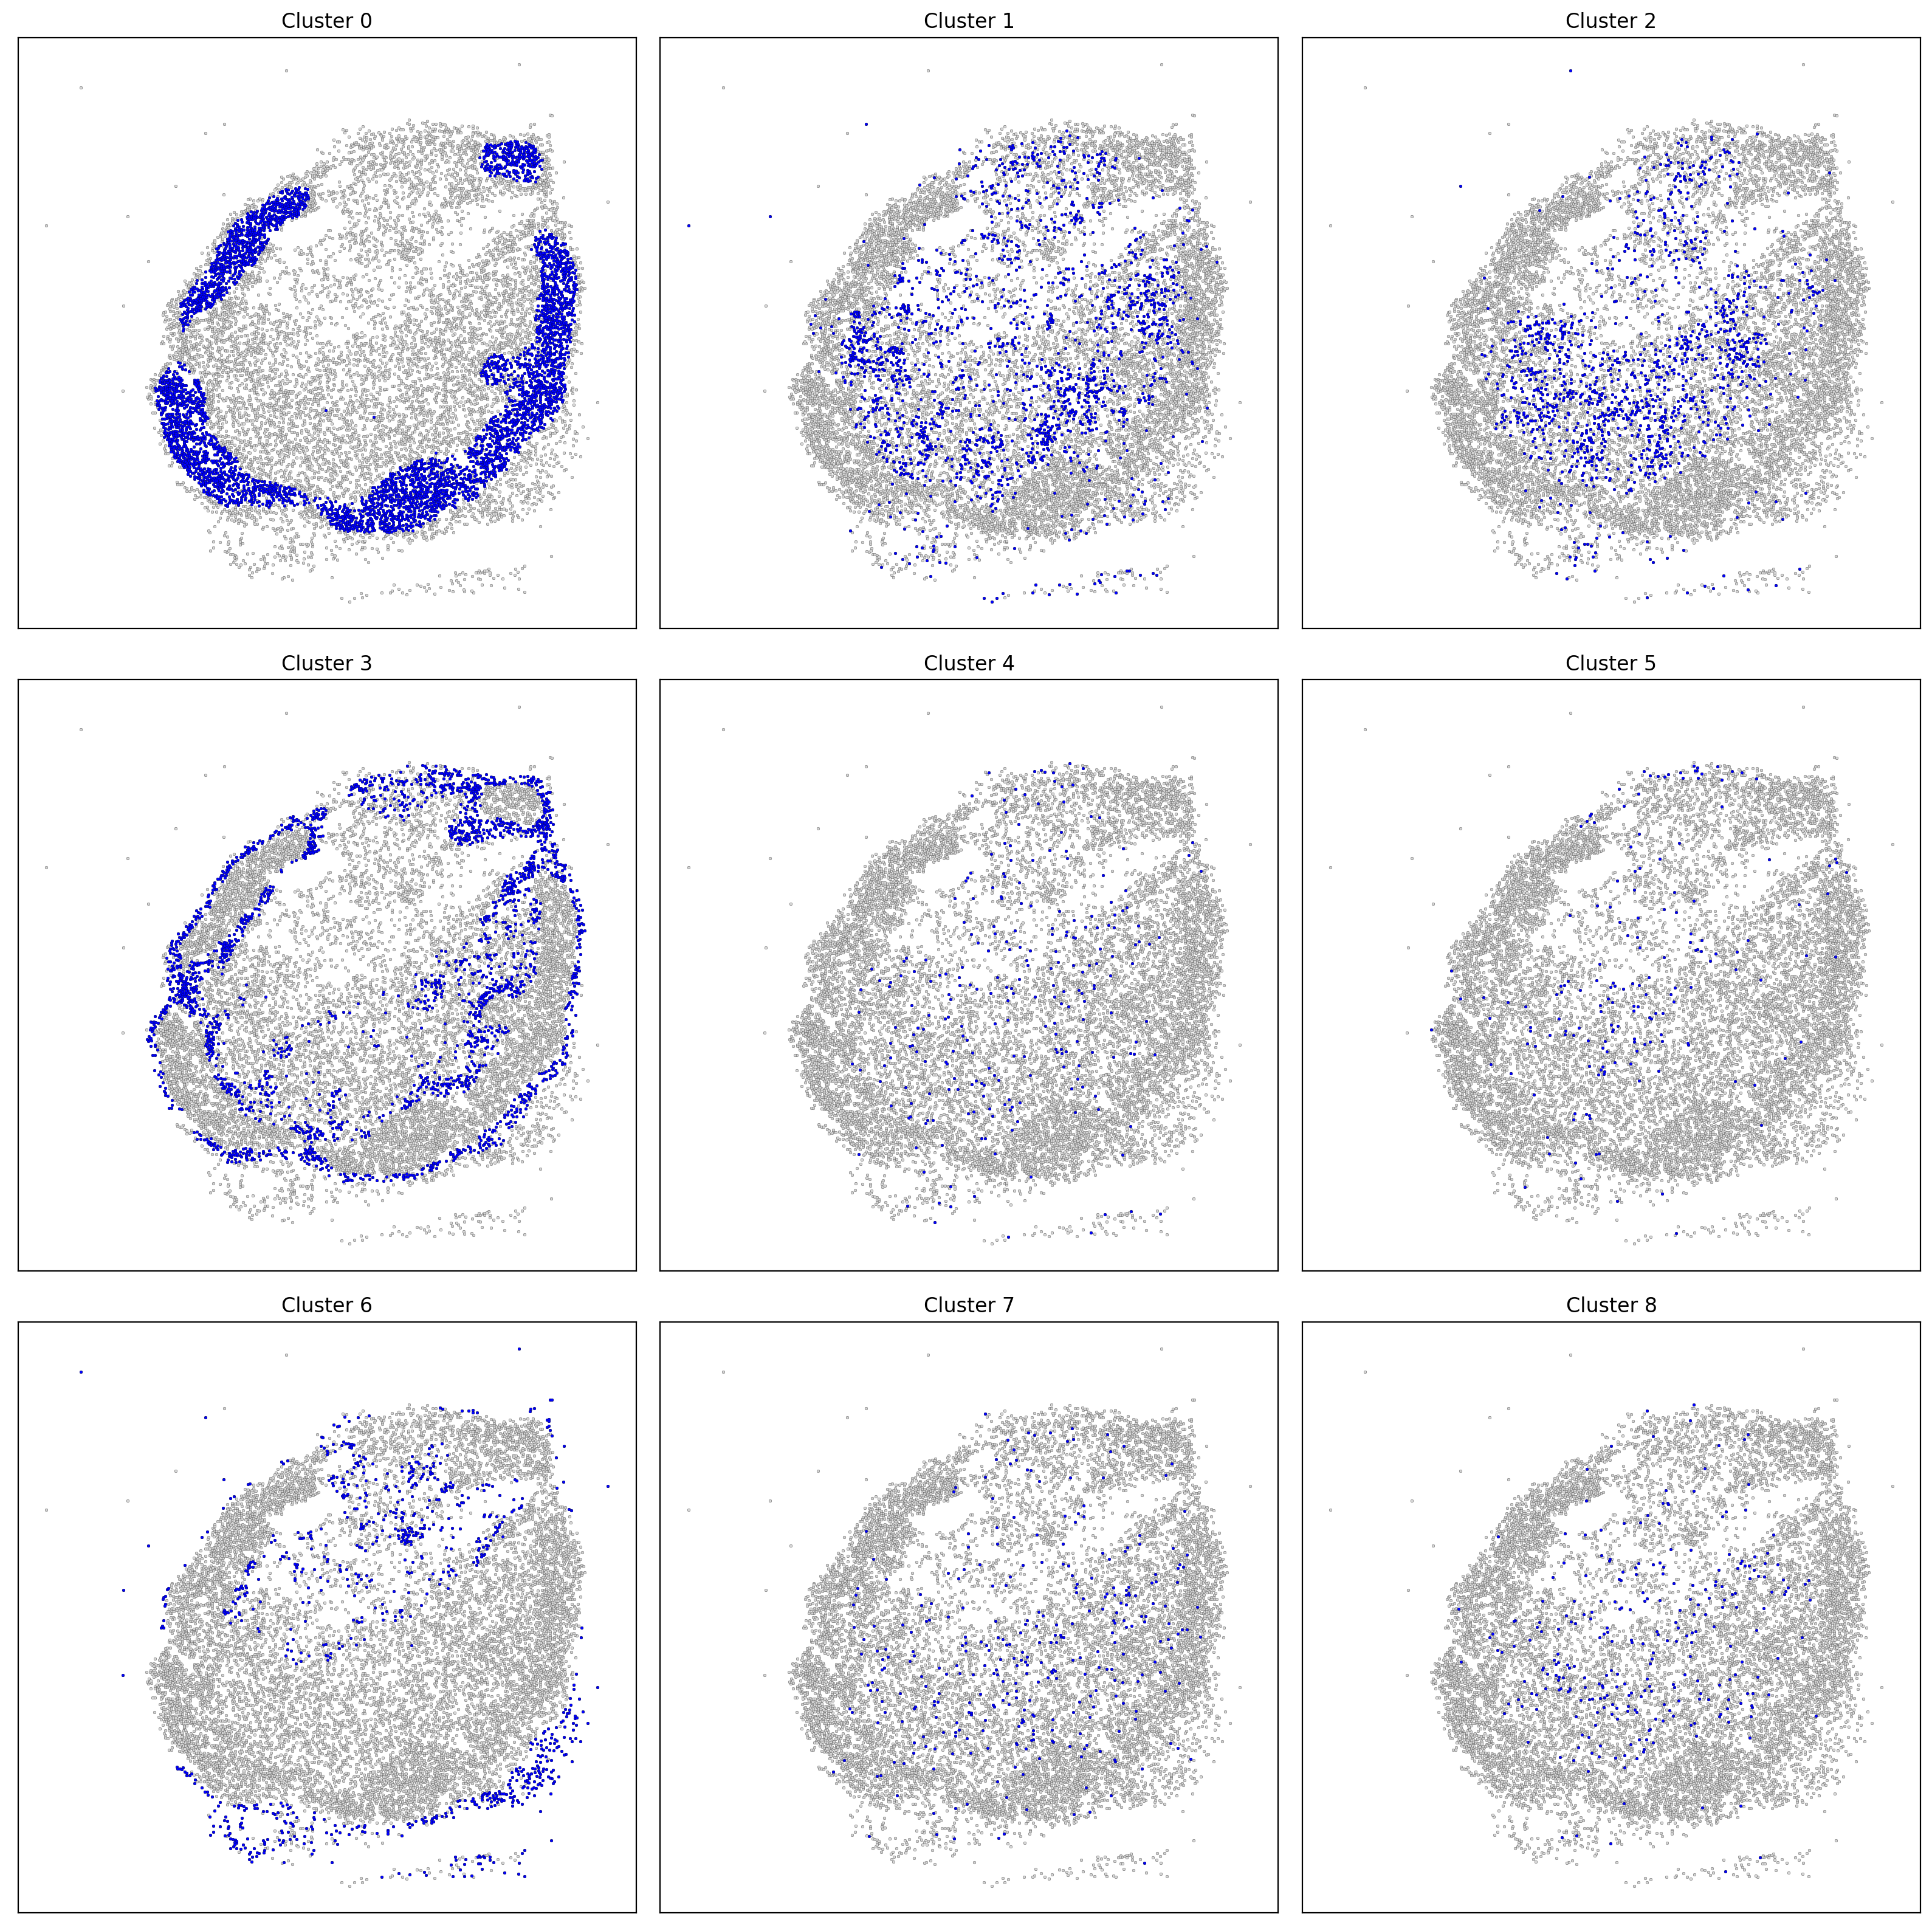

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 3, figsize=(16, 16))

axes = axes.ravel()

for i in range(k):
    cluster_mask = labels == i
    
    axes[i].scatter(
        adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1],
        c='lightgray', s=3, edgecolors='black', linewidth=0.1
    )
    
    axes[i].scatter(
        adata.obsm['spatial'][cluster_mask, 0], adata.obsm['spatial'][cluster_mask, 1],
        c='blue', s=3, edgecolors='black', linewidth=0.1
    )
    
    axes[i].set_title(f'Cluster {i}')
    axes[i].set_xticks([])  
    axes[i].set_yticks([])  

plt.tight_layout()
plt.show()


In [12]:
from sklearn.preprocessing import MinMaxScaler

gem_simulated = np.load(f'.cache/lymph/{goi}_gem_simulated.npy')
so.adata.layers['simulated_count'] = gem_simulated

gene_mtx = so.adata.layers['imputed_count']
delta_X = gem_simulated - gene_mtx
so.adata.layers['delta_X'] = delta_X

In [ ]:
estimate_transitions_2D(
    so.adata, so.adata.layers['delta_X'], betas_pca[:, :2], 
    annot='rctd_cluster', normalize=True, vector_scale=0.02, n_jobs=1)

randomize_transitions_2D(
    so.adata, so.adata.layers['delta_X'], betas_pca[:, :2], 
    annot='rctd_cluster', normalize=True, vector_scale=0.02, n_jobs=1)

In [ ]:
estimate_celltype_transitions(
    so.adata, so.adata.layers['delta_X'], betas_pca[:, :2], 
    annot='rctd_celltypes', n_neighbors=200, vector_scale=1,
    visual_clusters=['B-cell', 'Th2', 'Tfh'], n_jobs=1)

In [ ]:
from spaceoracle.plotting.layout import show_beta_neighborhoods

show_beta_neighborhoods(so, goi, annot='rctd_celltypes', clusters=None)